<a href="https://colab.research.google.com/github/enzogranado/Machine-Learning/blob/main/C%C3%B3pia_de_Lab_aula_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#  **Laboratório - aula 7**

O dataset deste laboratório inclui dados históricos sobre vendas de veículos elétricos em várias regiões e anos. Ele é usado principalmente para análise de tendências e previsões na indústria de veículos elétricos.








|     | Descrição                                                                                                                       |
| -------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **region**     | Área geográfica ou país (ex.: Mundo, China, Estados Unidos, Europa, etc.))                                                      |
| **category**   | Categoria dos dados – sempre "Historical" neste dataset                                                                               |
| **parameter**  | Tipo de métrica de vendas (ex.: EV sales, EV stock, EV stock share, EV sales share)                              |
| **mode**       | Sempre "Cars" – indica que este dataset foca em veículos de passageiros                                                              |
| **powertrain** | Tipo de motor elétrico: BEV (Battery Electric), PHEV (Plug-in Hybrid), FCEV (Fuel Cell Electric Vehicle) ou EV (elétrico genérico) |
| **year**       | Ano em que os dados foram registrados (variando de 2010 a 2023)                                                                        |
| **unit**       | Unidade de medida: Vehicles, percent, shares, etc.                                                             |
| **value**      | Valor numérico para a métrica correspondente (ex.: número de veículos vendidos)                                                       |


Fonte: International Energy Agency (IEA)

---

## **1. Panorama dos Dados**

### Bibliotecas necessárias

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")

### Carregar dataset

In [9]:
df = pd.read_csv("/content/IEA-EV-dataEV salesHistoricalCars.csv")

In [10]:
print("Dataset shape:", df.shape)

Dataset shape: (3798, 8)


In [11]:
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


### Tipo dos dados e missing values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


## **2. Engenharia de Features**

### Filtrar apenas as EV sales

In [13]:
ev_sales_df = df[(df['parameter'] == 'EV sales') &
                 (~df['region'].isin(["World", "Europe", "EU27", "Rest of the world"]))]

### Agrupar e calcular o total de EV sales por região e ano-por-ano

In [14]:
region_year_sales = ev_sales_df.groupby(['region', 'year'])['value'].sum().reset_index()
region_year_sales.rename(columns={'value': 'total_sales'}, inplace=True)

region_year_sales['cumulative_sales'] = region_year_sales.groupby('region')['total_sales'].cumsum()
region_year_sales['yoy_growth'] = region_year_sales.groupby('region')['total_sales'].pct_change() * 100

region_year_sales.head(10)

,region,year,total_sales,cumulative_sales,yoy_growth
0,Australia,2011,49.0,49.0,NaN
1,Australia,2012,250.0,299.0,410.204082
2,Australia,2013,290.0,589.0,16.000000
3,Australia,2014,1320.0,1909.0,355.172414
4,Australia,2015,1760.0,3669.0,33.333333
5,Australia,2016,1370.0,5039.0,-22.159091
6,Australia,2017,2300.0,7339.0,67.883212
7,Australia,2018,3600.0,10939.0,56.521739
8,Australia,2019,9200.0,20139.0,155.555556
9,Australia,2020,6900.0,27039.0,-25.000000


## **3. Visualização**

### Heatmap: Vendas por região/país por ano

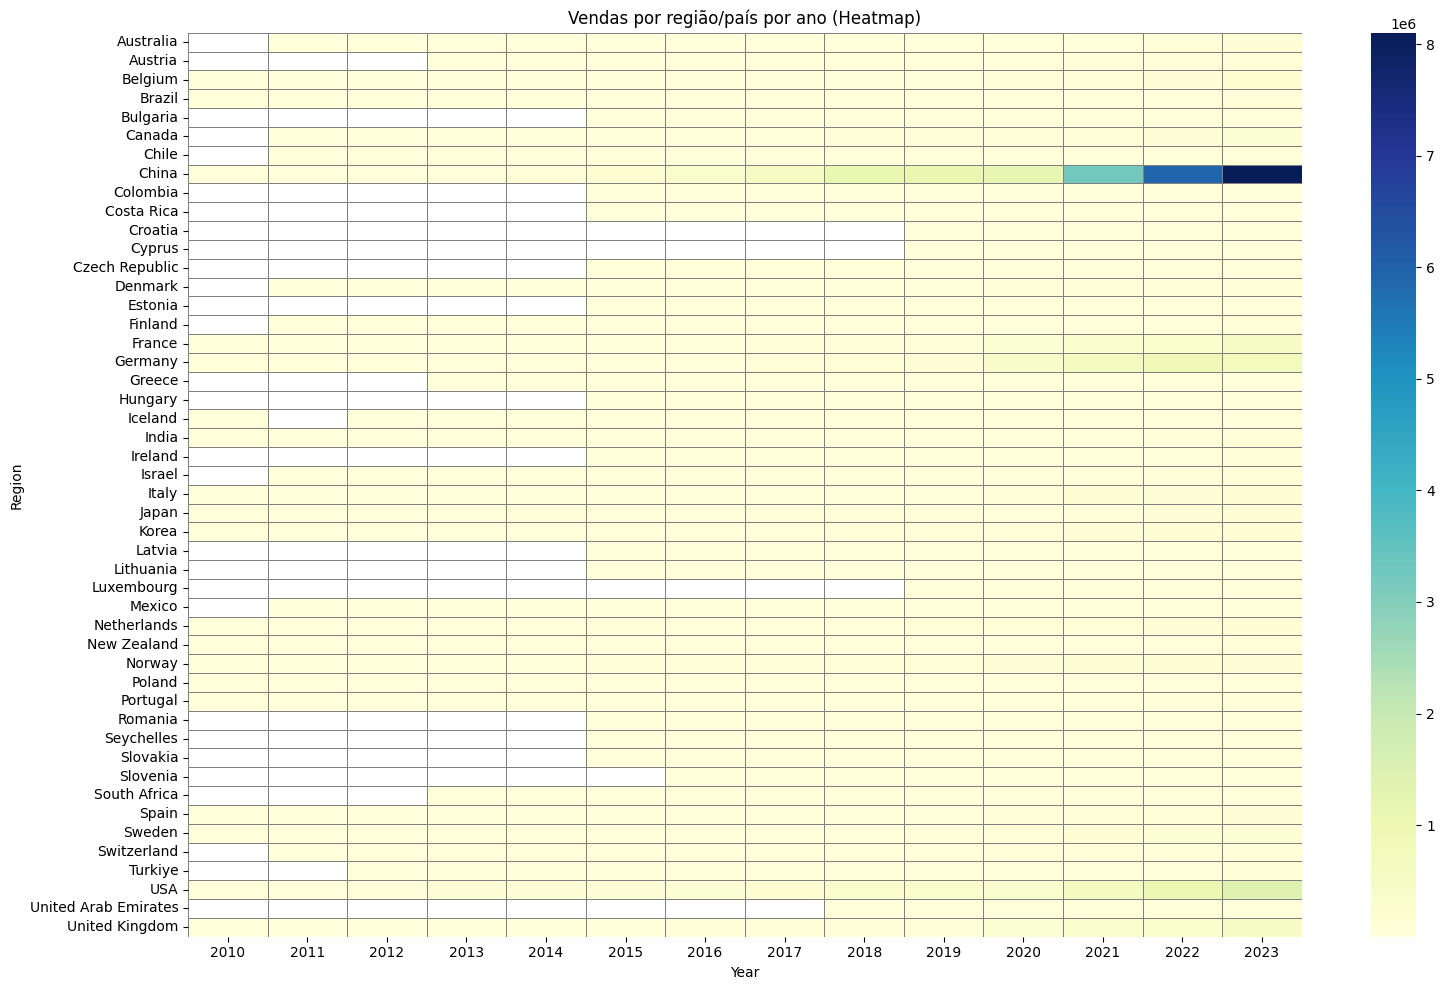

In [15]:
heatmap_data = region_year_sales.pivot(index='region', columns='year', values='total_sales')

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Vendas por região/país por ano (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### Gráfico: Vendas globais por ano

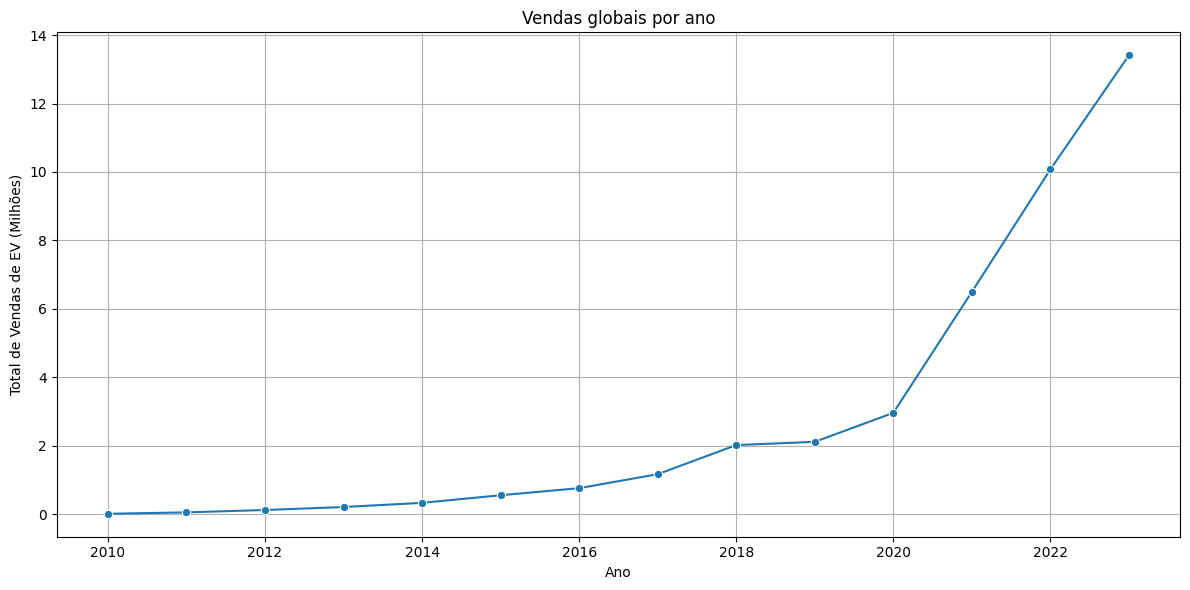

In [16]:
global_sales = ev_sales_df.groupby('year')['value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=global_sales, x='year', y='value', marker='o')
plt.title('Vendas globais por ano')
plt.xlabel('Ano')
plt.ylabel('Total de Vendas de EV (Milhões)')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1e6)}'))
plt.grid(True)
plt.tight_layout()
plt.show()

### Gráfico: Top países por vendas

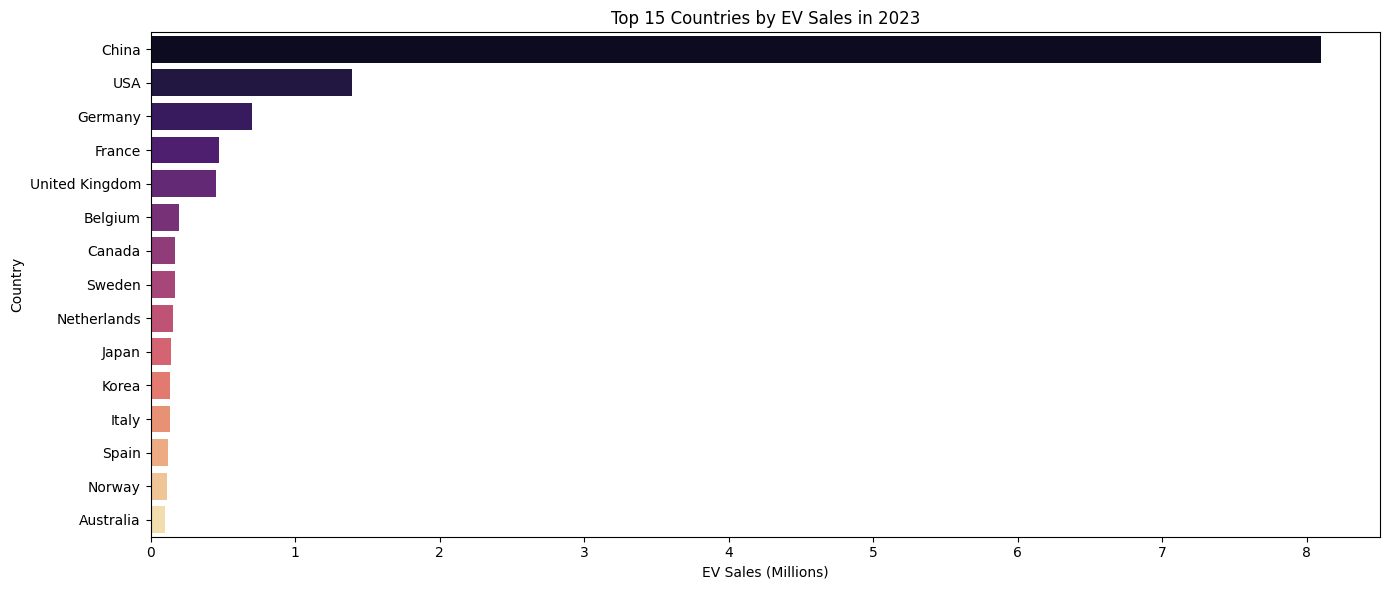

In [17]:
latest_year = ev_sales_df['year'].max()
top_countries = ev_sales_df[ev_sales_df['year'] == latest_year].groupby('region')['value'].sum().reset_index()
top_countries = top_countries.sort_values(by='value', ascending=False).head(15)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_countries, x=top_countries['value'] / 1e6, y='region', palette='magma')
plt.title(f'Top 15 Countries by EV Sales in {latest_year}')
plt.xlabel('EV Sales (Millions)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### Gráfico: Tendência de vendas de Powertrain

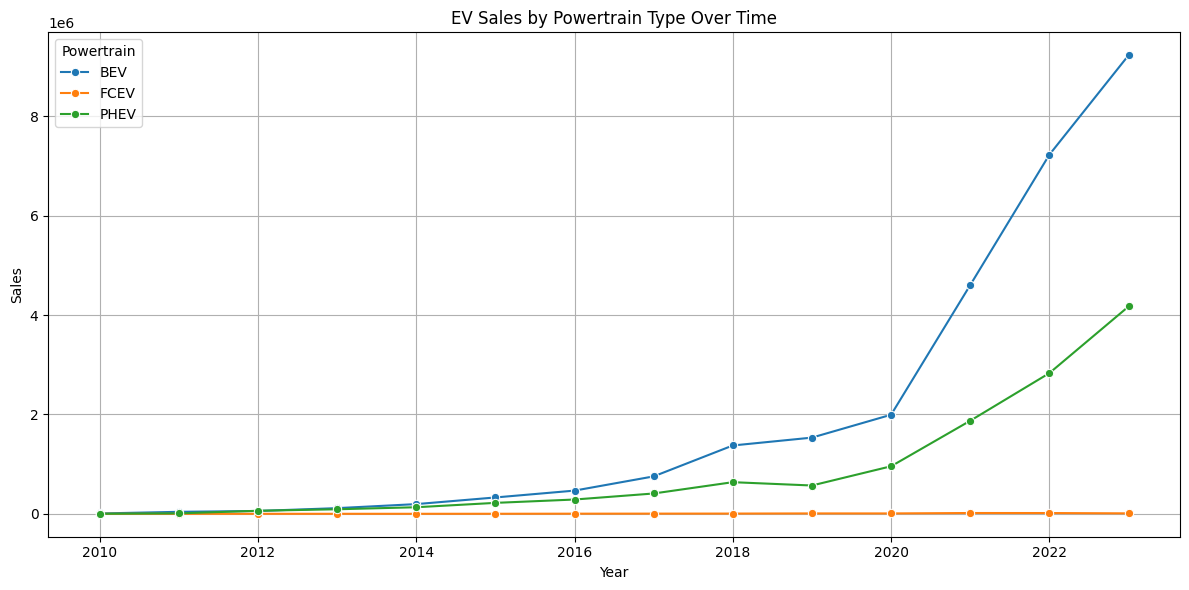

In [18]:
powertrain_trend = ev_sales_df.groupby(['year', 'powertrain'])['value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=powertrain_trend, x='year', y='value', hue='powertrain', marker='o')
plt.title('EV Sales by Powertrain Type Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Powertrain')
plt.grid(True)
plt.tight_layout()
plt.show()

## **4. Modelos de Deep Learning**

### Preparar dados

In [19]:
dl_df = df[(~df['region'].isin(["World", "Europe", "EU27", "Rest of the world"]))]

dl_df = dl_df[dl_df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
dl_df.rename(columns={'value': 'total_sales'}, inplace=True)

In [20]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(dl_df[['total_sales']])

### Plotar o histórico e uma simulação de linha da estimativa

In [21]:
future_years = pd.DataFrame({'year': list(range(2024, 2031))})
future_preds = future_years

In [22]:
X = dl_df[['year']]
y = dl_df['total_sales']

historical_df = X.copy()
historical_df['total_sales'] = y
historical_df['type'] = 'Histórico'

future_df = future_years.copy()
future_df['total_sales'] = future_preds
future_df['type'] = 'Estimativa'

combined_df = pd.concat([historical_df, future_df], axis=0).reset_index(drop=True)

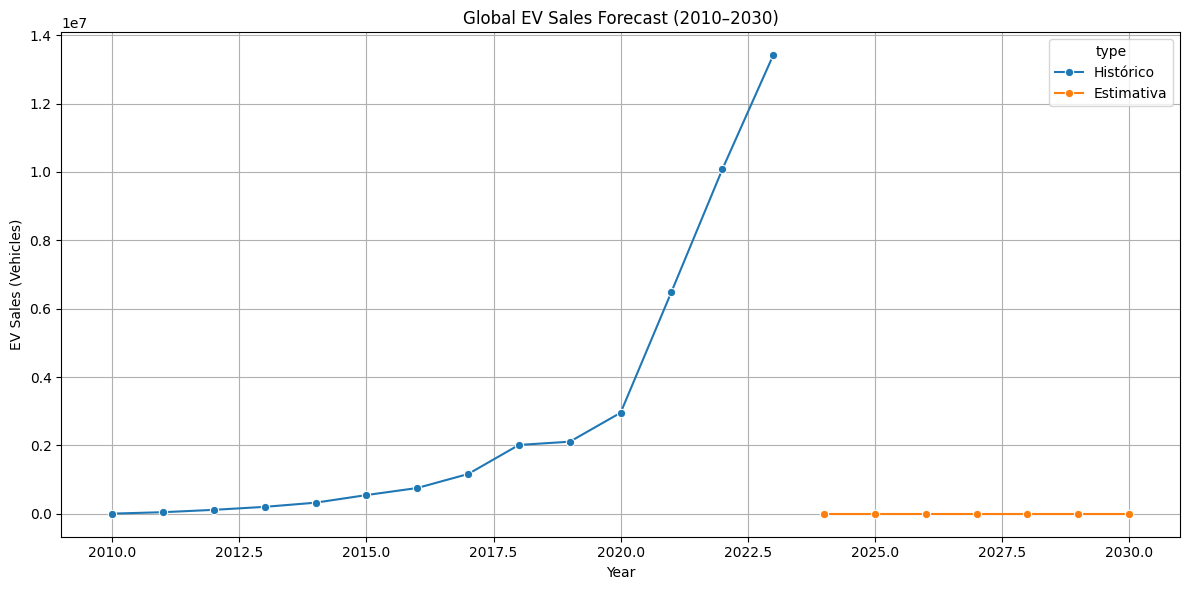

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='year', y='total_sales', hue='type', marker='o')
plt.title("Global EV Sales Forecast (2010–2030)")
plt.xlabel("Year")
plt.ylabel("EV Sales (Vehicles)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Criar sequências (tamanho da janela = 3 anos)

In [24]:
X_dl, y_dl = [], []
window = 3
for i in range(window, len(scaled_sales)):
    X_dl.append(scaled_sales[i-window:i])
    y_dl.append(scaled_sales[i])

X_dl, y_dl = np.array(X_dl), np.array(y_dl)

### Dividir em treino/teste

In [25]:
split = int(0.8 * len(X_dl))
X_train_dl, X_test_dl = X_dl[:split], X_dl[split:]
y_train_dl, y_test_dl = y_dl[:split], y_dl[split:]

## P.: Quantos % dos dados viraram dados de treino e quantos % viraram dados de teste?
80% dos dados viraram treino e 20% dos dados viraram teste

### **Modelo Dense Neural Network**

In [26]:
model_dense = Sequential([
    Flatten(input_shape=(X_train_dl.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_dense.compile(optimizer='adam', loss='mse')
history_dense = model_dense.fit(X_train_dl, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_dl, y_test_dl))

### **Modelo LSTM**

In [27]:
#Reformatar para entrada do LSTM
X_train_lstm = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_lstm = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))

In [28]:
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train_lstm, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_lstm, y_test_dl))

In [29]:
# Modelo Denso
y_dense_test_pred = model_dense.predict(X_test_dl, verbose=0)
y_dense_test_pred_inv = scaler.inverse_transform(y_dense_test_pred)

# Modelo LSTM
y_lstm_test_pred = model_lstm.predict(X_test_lstm, verbose=0)
y_lstm_test_pred_inv = scaler.inverse_transform(y_lstm_test_pred)

# Valores reais (iguais para ambos)
y_test_inv = scaler.inverse_transform(y_test_dl)


In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Feedforward NN
mse_dense = mean_squared_error(y_test_inv, y_dense_test_pred_inv)
rmse_dense = np.sqrt(mse_dense)

# LSTM
mse_lstm = mean_squared_error(y_test_inv, y_lstm_test_pred_inv)
rmse_lstm = np.sqrt(mse_lstm)

metrics_df = pd.DataFrame({
    "Modelo": ["Feedforward NN", "LSTM"],
    "MSE": [mse_dense, mse_lstm],
    "RMSE": [rmse_dense, rmse_lstm]
})

metrics_df[["MSE", "RMSE"]] = metrics_df[["MSE", "RMSE"]].round(2)
print(metrics_df)


           Modelo           MSE        RMSE
0  Feedforward NN  1.748099e+13  4181027.74
1            LSTM  1.062604e+13  3259761.29


### Comparar gráficos de loss

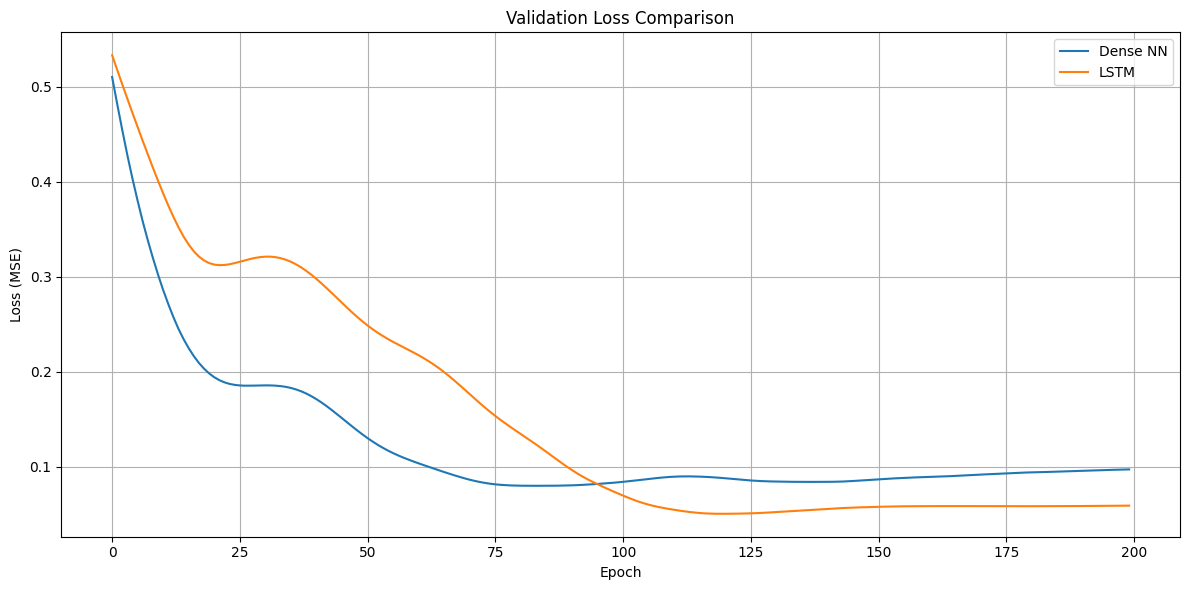

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history_dense.history['val_loss'], label='Dense NN')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### P.: O gráfico acima mostra a evolução da função de perda (validation loss) ao longo das rodadas de treinamento para os dois modelos: o Dense NN (linha azul) e o LSTM (linha laranja). O modelo Dense NN cai rapidamente porque aprende padrões básicos mais rápido. O LSTM começa com perda maior e aprende de forma mais lenta no início pq tem mais parâmetros e precisa “memorizar” relações temporais. O LSTM começa a melhorar gradualmente, reduzindo a perda de forma mais constante. O Dense NN atinge um platô cedo (~50 rodadas) e estabiliza com pequena oscilação, indicando que ele já extraiu tudo que podia dos padrões mais simples. Ao final, as curvas se aproximam e se estabilizam em valores parecidos mas ambas sobem um pouco no fim. Essa leve subida indica um underfitting ou overfitting? Justifique.
A leve subida indica um overfitting. Como o modelo passa a errar mais, significa que eles se adptaram aos dados de aprendizaram. Eles memorizam os dados em vez de aprender com padrões gerais.

## **5. Previsão de vendas de carros elétricos (2024–2030) com LSTM**

### Prever anos futuros usando o LSTM treinado

In [32]:
last_sequence = scaled_sales[-3:]  # Last 3 years for prediction window
predictions_scaled = []

for _ in range(7):  # Predict 2024–2030
    input_seq = last_sequence[-3:].reshape(1, 3, 1)
    pred = model_lstm.predict(input_seq, verbose=0)
    predictions_scaled.append(pred[0][0])
    last_sequence = np.append(last_sequence, pred[0][0])

In [33]:
predicted_values = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

### Plotar valores reais vs. previsão

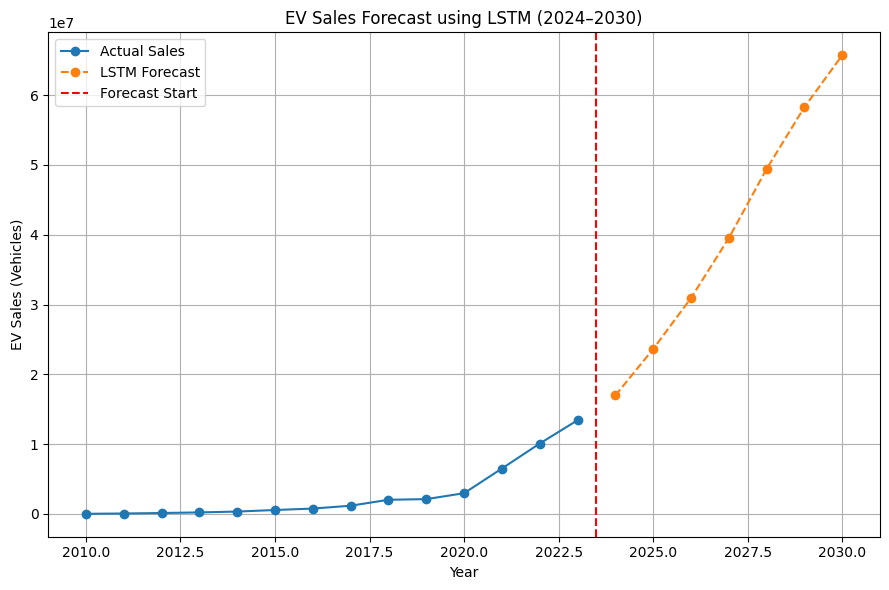

In [34]:
forecast_years = list(range(2024, 2031))

plt.figure(figsize=(9, 6))
plt.plot(X, y, marker='o', label='Actual Sales')
plt.plot(forecast_years, predicted_values, marker='o', linestyle='--', label='LSTM Forecast')
plt.axvline(x=2023.5, color='red', linestyle='--', label='Forecast Start')
plt.title("EV Sales Forecast using LSTM (2024–2030)")
plt.xlabel("Year")
plt.ylabel("EV Sales (Vehicles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **6. Interpretação dos resultados & Avaliação visual**

### LSTM: Valores reais vs. previsão (somente conjunto de teste)

In [35]:
y_lstm_test_pred = model_lstm.predict(X_test_lstm, verbose=0)
y_lstm_test_pred_inv = scaler.inverse_transform(y_lstm_test_pred)
y_test_dl_inv = scaler.inverse_transform(y_test_dl)

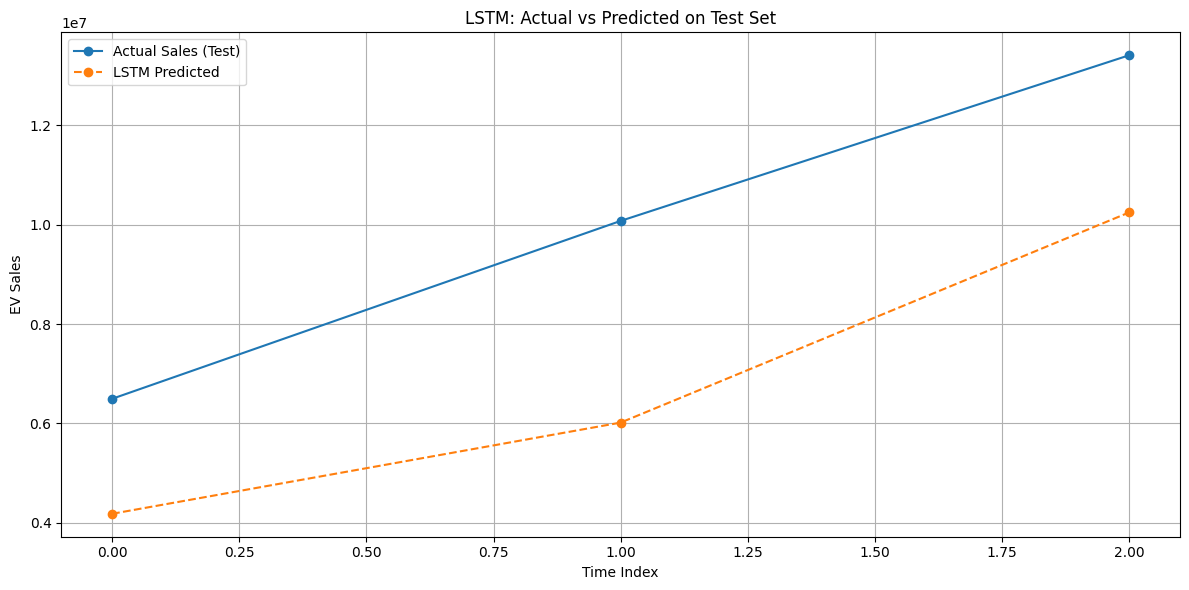

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_dl_inv)), y_test_dl_inv, label='Actual Sales (Test)', marker='o')
plt.plot(range(len(y_lstm_test_pred_inv)), y_lstm_test_pred_inv, label='LSTM Predicted', marker='o', linestyle='--')
plt.title("LSTM: Actual vs Predicted on Test Set")
plt.xlabel("Time Index")
plt.ylabel("EV Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## P.: Sobre o funcionamento de redes neurais do tipo LSTM na previsão (forecasting) de séries temporais, assinale a **alternativa FALSA**:

A) As LSTMs aprendem padrões temporais observando sequências de dados passados (janelas de tempo) e tentando prever o próximo valor provável. Por exemplo, ao ver 100, 120, 150, o modelo aprende que o próximo pode ser algo próximo de 180.

B) As LSTMs possuem “células de memória” capazes de reter informações de longo prazo, permitindo identificar tendências e padrões que se repetem ao longo do tempo.

C) Para prever vários períodos à frente, o modelo pode usar suas próprias previsões anteriores como novas entradas, num processo chamado forecasting recursivo.

D) As LSTMs podem prever valores futuros sem precisar de dados anteriores, pois são capazes de inferir diretamente o comportamento a partir de seus pesos internos.

Resp.: D

## P.: Em séries temporais, como é escolhida a amostra de treino para treinar uma rede LSTM que prevê valores futuros?

A) O treino pega os dados mais antigos da série, preservando a ordem temporal, para que o modelo aprenda padrões históricos antes de prever o futuro.

B) O treino seleciona uma amostra aleatória de toda a série, misturando passado e futuro, já que a ordem dos dados não importa.

C) O treino usa apenas os dados do meio da série, ignorando o começo e o fim, para focar em padrões “típicos”.

D) O treino pode incluir dados futuros, desde que o modelo saiba a sequência correta, porque isso melhora a precisão das previsões.

Resp.: A